Dataset Shape: (1118669, 34)


,transaction_id,order_date,customer_id,product_id,product_name,category,subcategory,brand,original_price_inr,discount_percent,...,is_festival_sale,festival_name,customer_rating,return_status,order_month,order_year,order_quarter,product_weight_kg,is_prime_eligible,product_rating
0,TXN_2015_00000001,2015-01-25,CUST_2015_00003884,PROD_000021,Samsung Galaxy S6 16GB Black,Electronics,Smartphones,Samsung,123614.29,27.91,...,True,Republic Day Sale,5.0,Delivered,1,2015,1,0.19,True,4.7
1,TXN_2015_00000002,2015-05-01,CUST_2015_00011709,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.5,Delivered,1,2015,1,0.20,True,4.1
2,TXN_2015_00000003,2015-01-24,CUST_2015_00004782,PROD_000039,Samsung Galaxy Note 5 64GB Black,Electronics,Smartphones,Samsung,97644.25,46.93,...,True,Republic Day Sale,NaN,Delivered,1,2015,1,0.17,True,3.3
3,TXN_2015_00000004,2015-01-28,CUST_2015_00008105,PROD_000085,Motorola Moto G (3rd Gen) 16GB Black,Electronics,Smartphones,Motorola,21947.26,0.00,...,False,NaN,3.0,Delivered,1,2015,1,0.22,True,3.5
4,TXN_2015_00000005,2015-01-31,CUST_2015_00002955,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.0,Delivered,1,2015,1,0.20,True,4.1


----- PRODUCT RATING IMPACT ON SALES -----


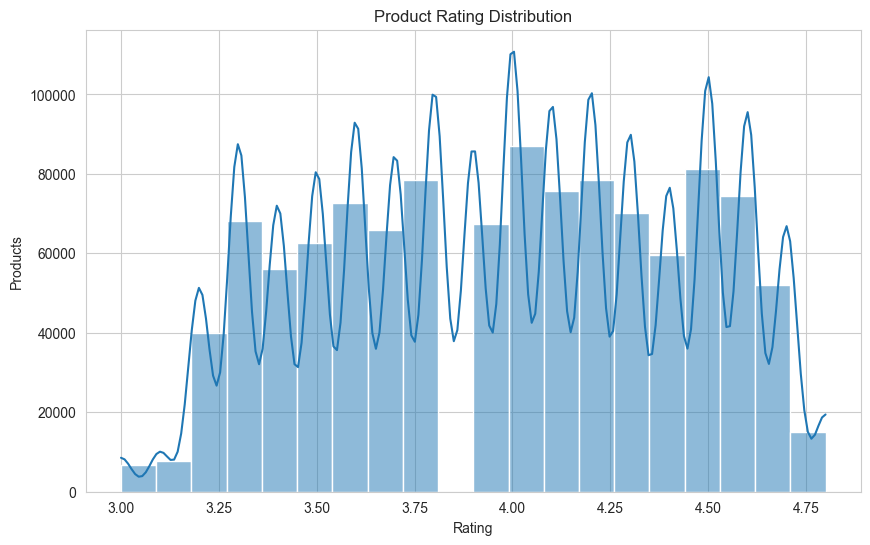

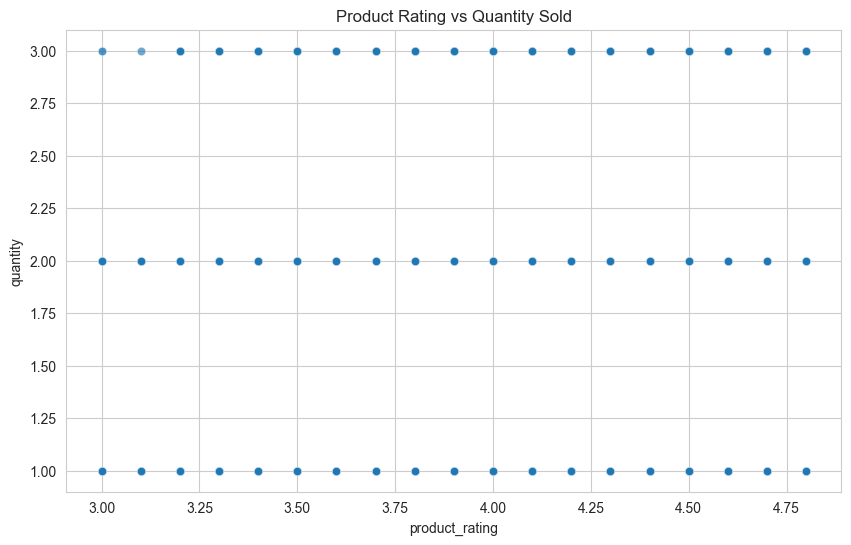

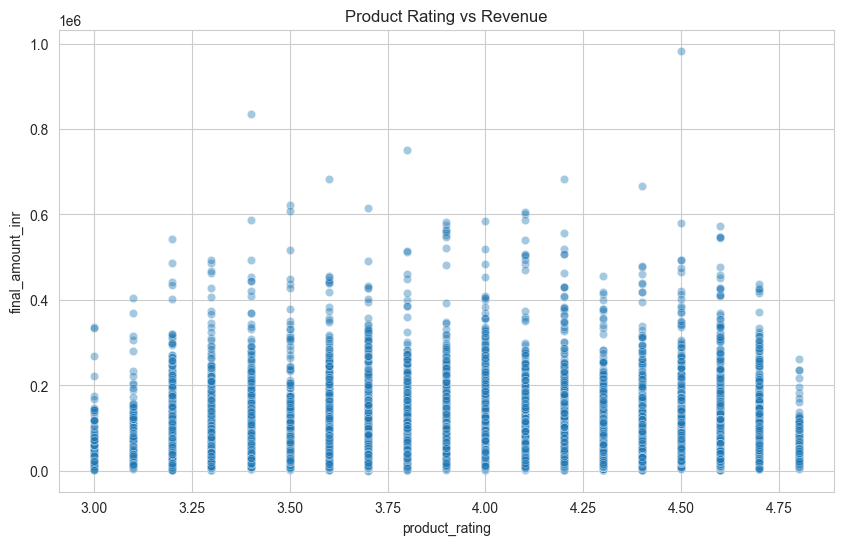

,rating_band,avg_qty,avg_revenue,total_revenue
0,2-3,1.247142,66656.394422,4.431317e+08
1,3-4,1.251729,67919.940103,4.114019e+10
2,4-5,1.252524,68757.624774,3.481233e+10


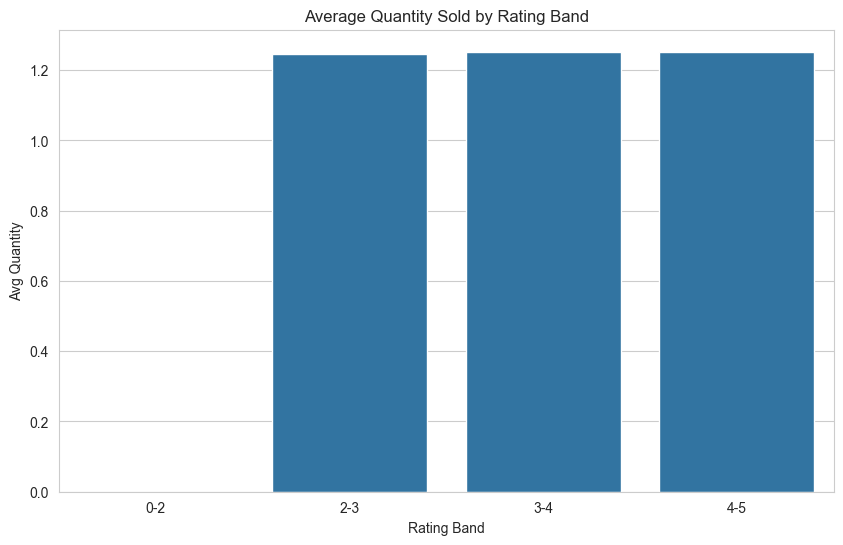

,avg_rating,total_qty,total_revenue
category,,,
Electronics,3.975193,1400642,7.639566e+10


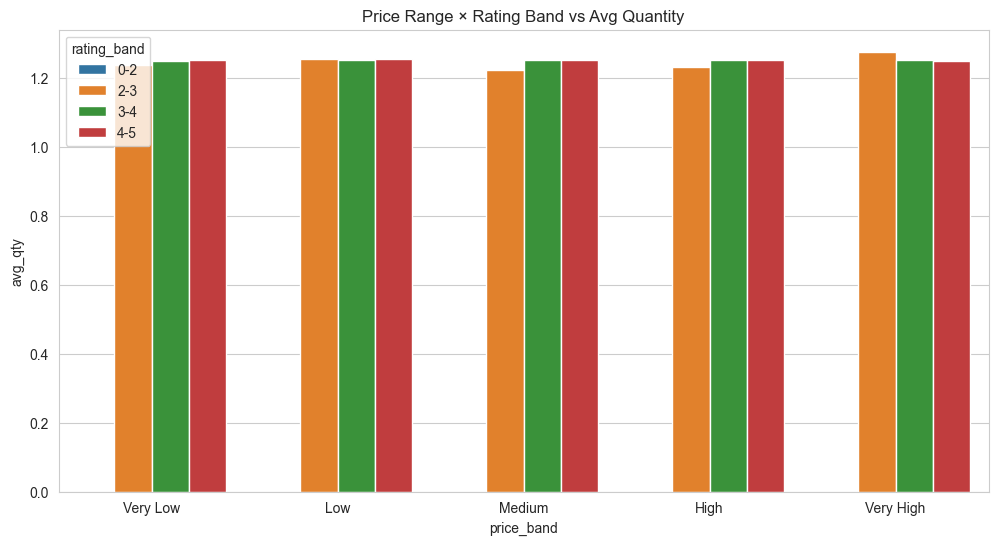

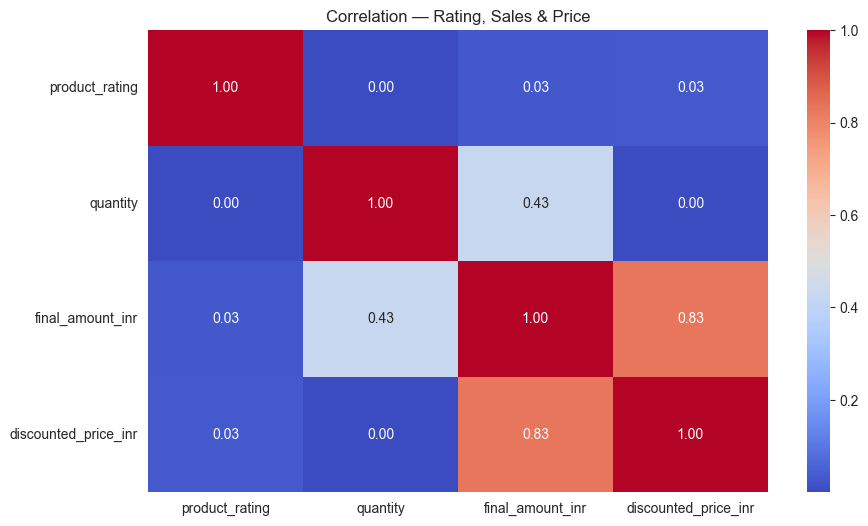

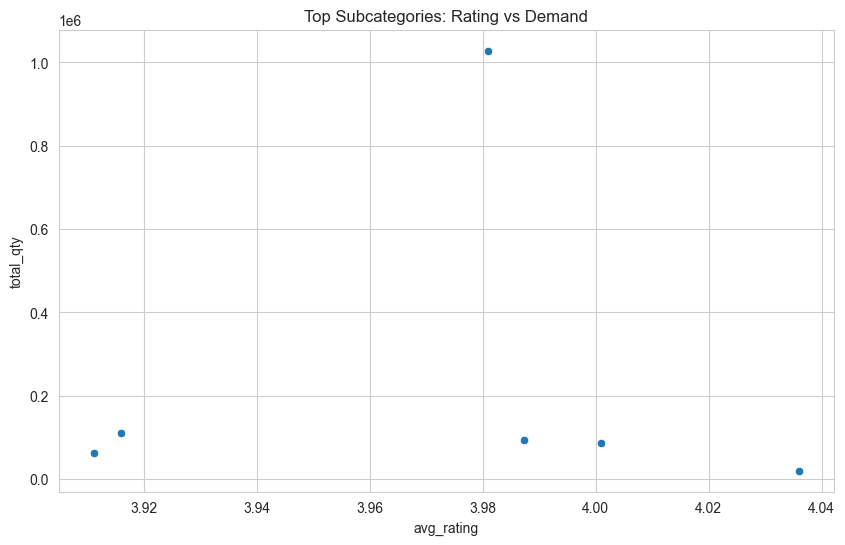

✅ EDA_11 COMPLETED SUCCESSFULLY


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ============================================================
# LOAD MASTER DATA
# ============================================================

df = pd.read_csv("../master/amazon_india_master_2015_2025.csv")

print("Dataset Shape:", df.shape)
display(df.head())

# ============================================================
# BASIC CLEAN
# ============================================================

num_cols = [
    "product_rating",
    "quantity",
    "final_amount_inr",
    "discounted_price_inr",
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Keep only rows with rating + sales
df = df.dropna(
    subset=[
        "product_rating",
        "quantity",
        "final_amount_inr",
        "category",
    ]
)

# ============================================================
# QUESTION 16 : PRODUCT RATINGS & SALES
# ============================================================

print("----- PRODUCT RATING IMPACT ON SALES -----")

# ------------------------------------------------------------
# Rating Distribution
# ------------------------------------------------------------

plt.figure(figsize=(10,6))
sns.histplot(df["product_rating"], bins=20, kde=True)
plt.title("Product Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Products")
plt.show()

# ------------------------------------------------------------
# Rating vs Quantity Sold
# ------------------------------------------------------------

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df.sample(20000, random_state=42),
    x="product_rating",
    y="quantity",
    alpha=0.4
)
plt.title("Product Rating vs Quantity Sold")
plt.show()

# ------------------------------------------------------------
# Rating vs Revenue
# ------------------------------------------------------------

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df.sample(20000, random_state=42),
    x="product_rating",
    y="final_amount_inr",
    alpha=0.4
)
plt.title("Product Rating vs Revenue")
plt.show()

# ------------------------------------------------------------
# Average Sales by Rating Band
# ------------------------------------------------------------

df["rating_band"] = pd.cut(
    df["product_rating"],
    bins=[0,2,3,4,5],
    labels=["0-2","2-3","3-4","4-5"]
)

rating_perf = (
    df.groupby("rating_band")
      .agg(
          avg_qty=("quantity","mean"),
          avg_revenue=("final_amount_inr","mean"),
          total_revenue=("final_amount_inr","sum")
      )
      .reset_index()
)

display(rating_perf)

# ------------------------------------------------------------
# Rating Band vs Avg Quantity
# ------------------------------------------------------------

plt.figure(figsize=(10,6))
sns.barplot(
    data=rating_perf,
    x="rating_band",
    y="avg_qty"
)
plt.title("Average Quantity Sold by Rating Band")
plt.xlabel("Rating Band")
plt.ylabel("Avg Quantity")
plt.show()

# ------------------------------------------------------------
# Category-wise Rating Impact
# ------------------------------------------------------------

cat_rating = (
    df.groupby("category")
      .agg(
          avg_rating=("product_rating","mean"),
          total_qty=("quantity","sum"),
          total_revenue=("final_amount_inr","sum")
      )
      .sort_values("avg_rating", ascending=False)
)

display(cat_rating.head(15))

# ------------------------------------------------------------
# Price Range Buckets
# ------------------------------------------------------------

df["price_band"] = pd.qcut(
    df["discounted_price_inr"],
    q=5,
    labels=["Very Low","Low","Medium","High","Very High"]
)

price_rating = (
    df.groupby(["price_band","rating_band"])
      .agg(
          avg_qty=("quantity","mean"),
          revenue=("final_amount_inr","sum")
      )
      .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=price_rating,
    x="price_band",
    y="avg_qty",
    hue="rating_band"
)
plt.title("Price Range × Rating Band vs Avg Quantity")
plt.show()

# ------------------------------------------------------------
# Correlation Matrix
# ------------------------------------------------------------

corr_cols = [
    "product_rating",
    "quantity",
    "final_amount_inr",
    "discounted_price_inr",
]

plt.figure(figsize=(10,6))
sns.heatmap(
    df[corr_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation — Rating, Sales & Price")
plt.show()

# ------------------------------------------------------------
# Subcategory Deep Dive (Top 10 by Revenue)
# ------------------------------------------------------------

top_subcats = (
    df.groupby("subcategory")["final_amount_inr"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

subcat_rating = (
    df[df["subcategory"].isin(top_subcats)]
      .groupby("subcategory")
      .agg(
          avg_rating=("product_rating","mean"),
          total_qty=("quantity","sum")
      )
      .sort_values("avg_rating", ascending=False)
)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=subcat_rating,
    x="avg_rating",
    y="total_qty"
)
plt.title("Top Subcategories: Rating vs Demand")
plt.show()

print("✅ EDA_11 COMPLETED SUCCESSFULLY")
